# Plot filtered waveforms and spectrograms of gliders recorded on a subset of stations

In [7]:
# Imports
from os.path import join
from matplotlib.pyplot import subplots
from matplotlib.dates import DateFormatter
from matplotlib.dates import MinuteLocator, SecondLocator
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator
from pandas import Timestamp, Timedelta
from numpy import log10

from utils_basic import ROOTDIR_HYDRO, ROOTDIR_GEO, GEO_COMPONENTS, VELOCITY_UNIT, component_to_title, days_to_timestamps, save_figure
from utils_preproc import read_and_process_windowed_geo_waveforms, read_and_process_windowed_hydro_waveforms
from utils_spec import get_spectrogram_stft

In [8]:
# Inputs
## Data
starttime = Timestamp("2020-01-13T19:36:15Z")
stations_to_plot = ["A01", "A02", "A03", "A04", "A05", "A06"]

dur = 45.0 # seconds
rootdir_geo = ROOTDIR_GEO

## Preprocessing and STFT
freqmin = 60.0
freqmax = 90.0

window_length = 1

## Plotting
ylim_pres = (-0.5, 0.5)
ylim_vel = (-50.0, 50.0)
ylim_freq = (0.0, 150.0)

dbmin = -40.0
dbmax = 0.0

linewidth_wf = 0.5

linewidth_box = 1.5

xdim_ax = 7.5
ydim_ax = 1.5

freqmin_box = 60.0
freqmax_box = 120.0

major_locator = SecondLocator(interval=30)
minor_locator = SecondLocator(interval=5)

In [9]:
# Read the geophone data
stream = read_and_process_windowed_geo_waveforms(starttime, dur, stations=stations_to_plot, freqmin=freqmin, freqmax=freqmax)

In [10]:
# Compute the spectrograms
specdict_geo = {}

for station in stations_to_plot:
    for component in GEO_COMPONENTS:
        trace = stream.select(station=station, component=component)[0]

        freqax, timeax, spec = get_spectrogram_stft(trace, window_length=window_length, overlap=0.5)
        # print(timeax[0], timeax[-1])

        specdict_geo[(station, component)] = (freqax, timeax, spec)

(18274.816840277777, 18274.817361111112)

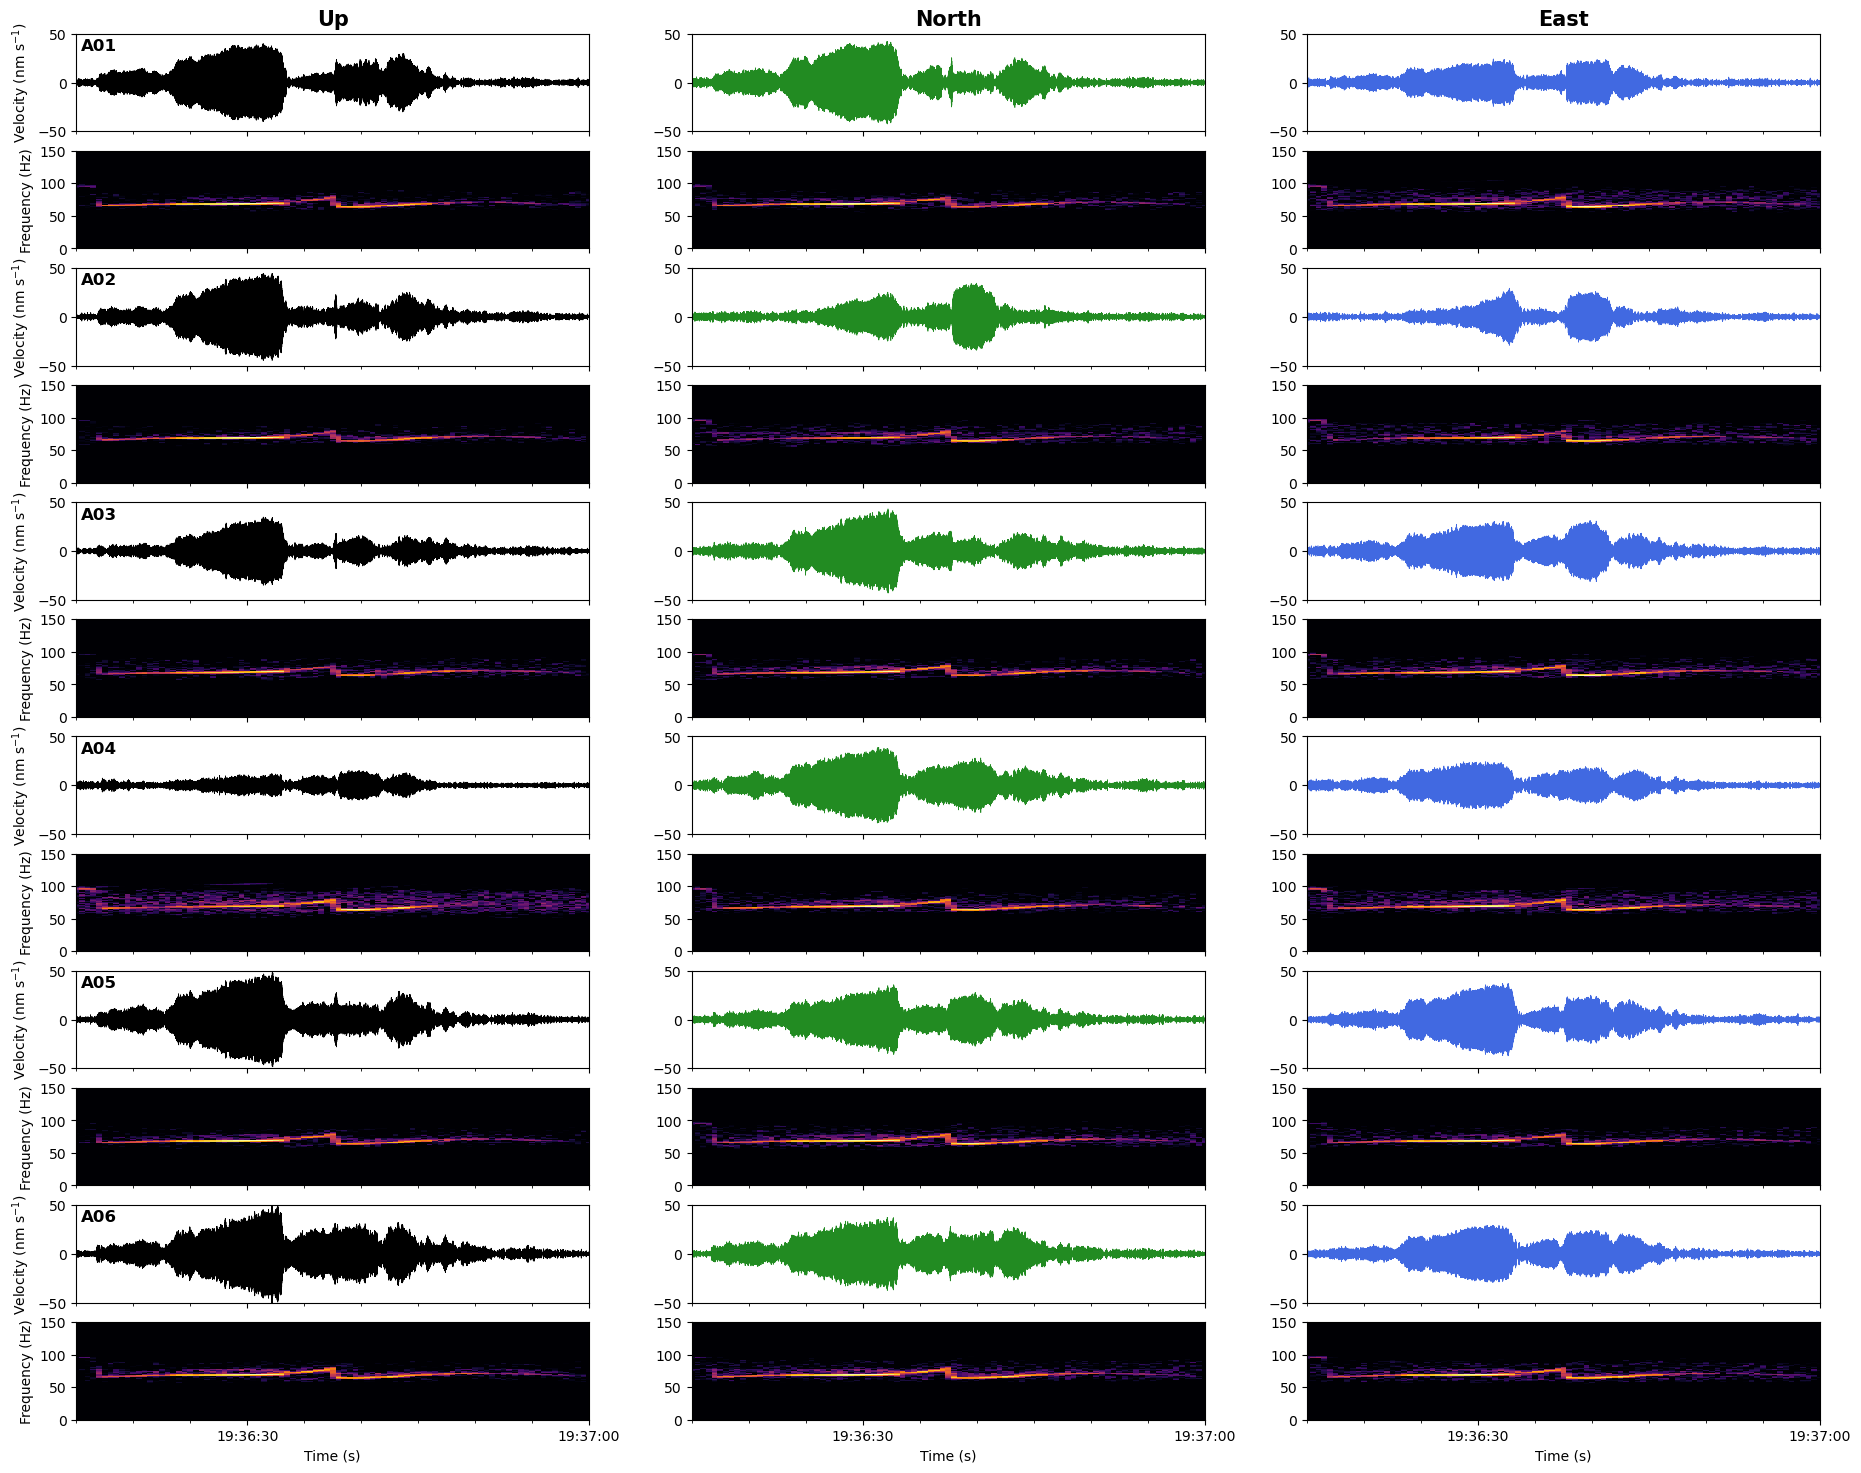

In [11]:
# Plot the waveforms and spectrograms
numsta = len(stations_to_plot)
fig, axes = subplots(2 * numsta, 3, figsize=(xdim_ax * 3, ydim_ax * numsta * 2), sharex=True)

for i, station in enumerate(stations_to_plot):
    for j, component in enumerate(GEO_COMPONENTS):
        ax_wf = axes[2 * i, j]
        ax_spec = axes[2 * i + 1, j]

        ## Waveform
        trace = stream.select(station=station, component=component)[0]
        data = trace.data
        timeax_wf = trace.times("matplotlib")
        timeax_wf = days_to_timestamps(timeax_wf)

        if component == "Z":
            ax_wf.plot(timeax_wf, data, "black", linewidth=linewidth_wf)
        elif component == "1":
            ax_wf.plot(timeax_wf, data, "forestgreen", linewidth=linewidth_wf)
        elif component == "2":
            ax_wf.plot(timeax_wf, data, "royalblue", linewidth=linewidth_wf)

        ax_wf.set_ylim(ylim_vel)

        if i == 0:
            ax_wf.set_title(component_to_title(component), fontsize=15, fontweight="bold")
        
        if j == 0:
            ax_wf.set_ylabel(f"Velocity ({VELOCITY_UNIT})")

        ## Spectrogram
        freqax, timeax_spec, spec = specdict_geo[(station, component)]

        ax_spec.pcolormesh(timeax_spec, freqax, spec, cmap="inferno", vmin=dbmin, vmax=dbmax)
        ax_spec.set_ylim(ylim_freq)

        if i == numsta - 1:
            ax_spec.set_xlabel("Time (s)")
            ax_spec.xaxis.set_major_locator(major_locator)
            ax_spec.xaxis.set_minor_locator(minor_locator)

        if j == 0:
            ax_spec.set_ylabel("Frequency (Hz)")
            ax_wf.text(0.01, 0.95, station, transform=ax_wf.transAxes, fontsize=12, fontweight="bold", ha="left", va="top")

# Set the x axis limits
ax = axes[0, 0]
ax.set_xlim(timeax_wf[0], timeax_wf[-1])


In [14]:
stream[0].stats.coordinates

AttributeError: coordinates